In [13]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [42]:
import matplotlib
matplotlib.__version__

'3.1.2'

In [2]:
assets = pd.read_csv('pricing.csv', index_col=0)

In [5]:
returns = assets.pct_change().dropna()

In [7]:
returns.head()

,AAPL,PETS,STMP,VZ,SO,T,FXY,FXB,FXF,VCLT
2015-01-05,-0.028172,-0.010352,-0.021013,-0.008305,-0.004254,-0.009448,0.007309,-0.005245,-0.005133,0.001611
2015-01-06,0.000094,-0.006276,-0.016312,0.010093,0.012002,0.001490,0.009839,-0.006741,-0.002580,0.010611
2015-01-07,0.014022,0.022456,0.024875,-0.006453,0.011055,0.001207,-0.005480,-0.002957,-0.005380,0.001909
2015-01-08,0.038422,-0.002059,0.002981,0.021433,0.000795,0.009949,-0.004164,-0.001618,-0.004161,-0.008151
2015-01-09,0.001072,-0.021320,-0.012312,-0.008902,-0.012714,-0.002985,0.009223,0.005401,0.004596,0.002989


In [37]:
returns.columns

Index(['AAPL', 'PETS', 'STMP', 'VZ', 'SO', 'T', 'FXY', 'FXB', 'FXF', 'VCLT'], dtype='object')

### Hierarchical Clustering

> Hierarchical clustering can be performed with a distance matrix. Then it repeatedly executed the following 2 steps:
1. Start by treating indivisual items as a cluster. Identify 2 clusters that are closest together
2. merge the 2 most similar clusters.

> This continues until all the clusters are merge together.


> The distance between 2 clusters can be computed based on length of the straight line, which is the Euclidean distance. This is called **measure of distance/similarity.**

> After selecting a distance metric, it is necessary to determine from where distance is computed. For example, it can be computed between the 2 similar parts of a cluster, the 2 least similar or some other criterion. This is called **Linkage Criteria**

In [9]:
# correlation matrix
corr = returns.corr()

In [10]:
# distance matrix
d_corr = np.sqrt(0.5*(1-corr))

/home/rocky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


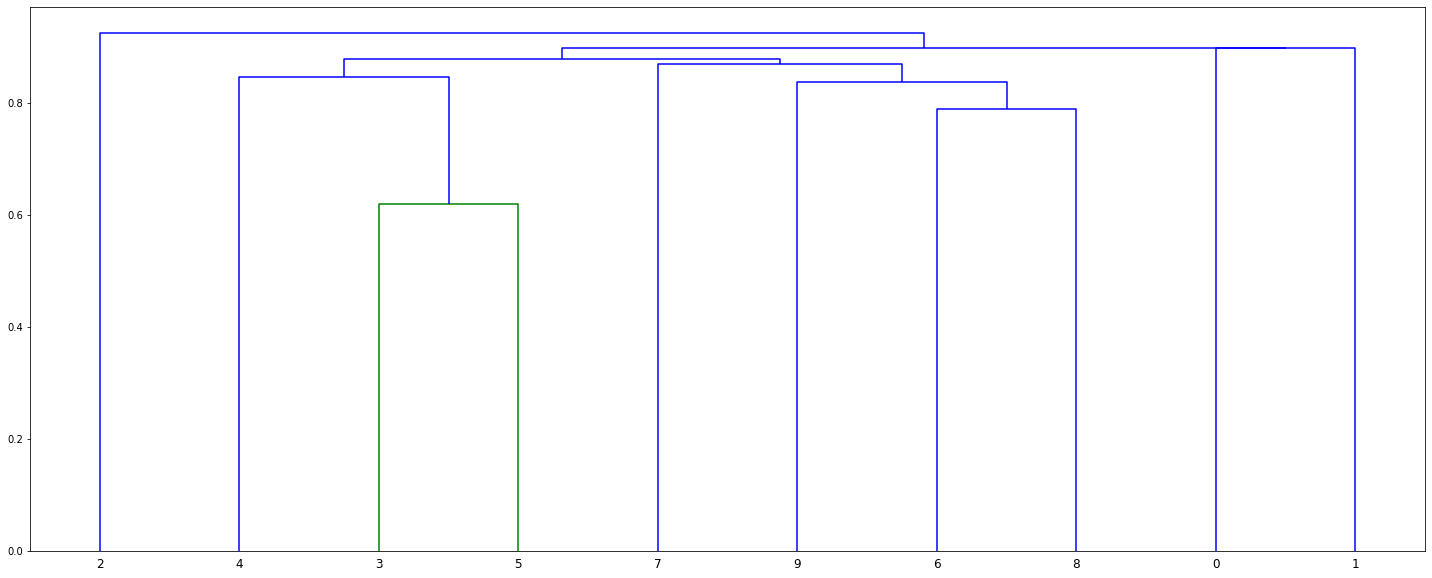

In [16]:
link = linkage(d_corr, 'single')
Z = pd.DataFrame(link)

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
# plt.show()

In [36]:
Z

,0,1,2,3
0,3.0,5.0,0.618707,2.0
1,6.0,8.0,0.788512,2.0
2,9.0,11.0,0.837068,3.0
3,4.0,10.0,0.845906,3.0
4,7.0,12.0,0.869022,4.0
5,13.0,14.0,0.878178,7.0
6,0.0,1.0,0.897254,2.0
7,15.0,16.0,0.898109,9.0
8,2.0,17.0,0.924699,10.0


> This stage allows us to define a linkage matrix as an (N-1)x4 matrix with structure $Y = \{(y_{m,1},y_{m,2},y_{m,3},y_{m,4})\}_{m=1,...N-1}$ (i.e, with one 4-tuple per cluster). Items ($y_{m,1}, y_{m.2}$) report the constituents. Item $y_m,3$ reports the distance between $y_{m,1}$ and $y_{m,2}$. Item $y_{m,4}$ reports the number of original items included in cluster $m$

### Quasi-Diagonalization

> This stage reorganizes the rows and columns of the covariance matrix, so that the largest values lie along the diagonal. This quasi-diagonalization of the covariance matrix renders a useful property - similar investments are placed together, and dissimilar investments are placed far apart. 

> The algorithm works as follows -
1. We know that each row of the linkage matrix megers 2 branches into 1. We replace clusters in ($y_{N-1, 1}, y_{N-1,2}$) with their constituents recursively, until no clusters remain.
2. These replacemnets preserve the order of the clustering.
3. The output is a sorted list fo original items. 

In [18]:
def get_quasi_diag(link):
    
    # sort clustered items by distance
    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        sort_ix = sort_ix.append(df0)
        sort_ix = sort_ix.sort_index()
        
        sort_ix.index = range(sort_ix.shape[0])
        
    
    return sort_ix.tolist()

In [19]:
sort_ix = get_quasi_diag(link)
sort_ix

[2, 4, 3, 5, 7, 9, 6, 8, 0, 1]

### Recursive Bisection

> Stage 2 has delivered a quasi-diagonal matrix. The inverse - variance is optimal for a diagonal covariance matrix. We can take advantage of these facts in 2 different ways 
1. bottom-up, to define the variance of a contiguous subset as teh variance of an inverse-variance allocation.
2. top-down, to split allocations between adjacent subsets in inverse proportion to their aggregated variances.

In [20]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var
def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        """
        [[3, 6, 0, 9, 2, 4, 13], [5, 12, 8, 10, 7, 1, 11]]
        [[3, 6, 0], [9, 2, 4, 13], [5, 12, 8], [10, 7, 1, 11]]
        [[3], [6, 0], [9, 2], [4, 13], [5], [12, 8], [10, 7], [1, 11]]
        [[6], [0], [9], [2], [4], [13], [12], [8], [10], [7], [1], [11]]
        """
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

In [30]:
cov = returns.cov()
weights = get_rec_bipart(cov, sort_ix)

In [31]:
new_index = [returns.columns[i] for i in weights.index]
weights.index = new_index

In [32]:
weights

STMP    0.004901
SO      0.082653
VZ      0.054359
T       0.045932
FXB     0.158309
VCLT    0.234561
FXY     0.194728
FXF     0.181731
AAPL    0.031296
PETS    0.011530
dtype: float64